<a href="https://colab.research.google.com/github/rikshith02/DeepRelation-VGG16-/blob/main/DeepRelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Would be trying VGG16 as a convolutional base to further increase performance accuracy of the network.

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

58889256/58889256 [==============================] - 0s 0us/step


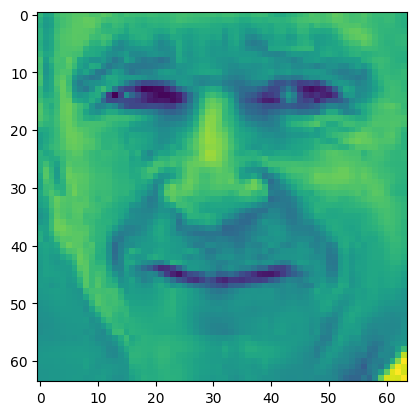

In [ ]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np


# The load data function loads the files(images) from all the classes (f-d, f-s, m-d, m-s), prepares labels for the same
# and calls import_dir which performs the function to merge the parent and child images into a single image as required for
# input to the model.
# returns all images from all folders into parent-child image form.
def load_data(dirs):
    all_images = []
    all_labels = []
    combination= {}
    label = 1
    for dir in sorted(os.listdir(dirs)):
        dir_name = os.path.join(dirs, dir)
        images, num_of_files = import_dir(dir_name)
        all_images.append(images)
        all_labels.append([label for i in range(num_of_files)])
        print(dir_name)
        print(len(images))
        label += 1
    return all_images, all_labels


# import_dir reads all files(images) for a given directory (say father-dau) and combines parent-child images to form a single
# 6 channel image which is used as input for the proposed model.
# The start variable is required to skip any thumbs.db file that may be present in the folder containing the images.
# return parent-child images for the given directory.

def import_dir(dir_name):
    files = sorted(os.listdir(dir_name))
    dir_images = []
    start = 0
    if len(files)%2 != 0:
        start = 1
    for file1, file2 in zip(files[start::2], files[start+1::2]):
        images = np.zeros((64, 64, 6))
        #if file.split('.')[0][-1] == "1":
        parent = plt.imread(os.path.join(dir_name, file1))
        images[:,:,0:3] = parent
        #if file.split('.')[0][-1] == "2":
        child = plt.imread(os.path.join(dir_name, file2))
        images[:,:,3:6] = child
#       plt.imshow(images[:,:,5])
#       plt.show()
#       input(" .... ")
#       print(file)
        dir_images.append(images)

    return dir_images, len(dir_images)

dir_images, length = import_dir("/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/father-dau")
plt.imshow(dir_images[58][:,:,1])


In [ ]:
# Using the load_data function obtain the train images (in paernt-child format) along with the labels for each class
# from the KinFaceW-II dataset.
train_images, train_labels = load_data("/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images")

/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/father-dau
134
/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/father-son
156
/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/mother-dau
127
/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/mother-son
116


In [ ]:
# Combine all train_images obtained into a single variable train_img
# Combine all train_labels obtained into a single variable train_labels
train_img = np.r_[train_images[0], train_images[1], train_images[2], train_images[3]]
train_labels = np.r_[np.array(train_labels[0]), np.array(train_labels[1]), np.array(train_labels[2]), np.array(train_labels[3])]

In [ ]:
# Obtain the test images (in parent-child form) along with the labels for each class
# from the KinFaceW-I dataset.
test_images, test_labels = load_data("/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images")

/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/father-dau
134
/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/father-son
156
/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/mother-dau
127
/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/mother-son
116


In [ ]:
# Combine all the test images into a single variable test_imgs
# Combine all the test labels into a single variable test_lab

test_img = np.zeros((len(test_images[0]) + len(test_images[1]) + len(test_images[2]) + len(test_images[3]), 64, 64, 6))
test_img = np.r_[test_images[0], test_images[1], test_images[2], test_images[3]]
test_lab = np.r_[np.array(test_labels[0]), np.array(test_labels[1]), np.array(test_labels[2]), np.array(test_labels[3])]
test_lab.shape

(533,)

In [ ]:
# Convert the labels into categorical variables for the multi-class classification task.

from keras.utils import to_categorical
train_labels_cat = to_categorical(train_labels - 1)
test_labels_cat = to_categorical(test_lab - 1)

In [ ]:
# Prepare datagenerator for Data Augmetnation

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

datagen.fit(train_img)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:2093: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (533, 64, 64, 6) (6 channels).
  warnings.warn(


In [ ]:
from keras import layers
from keras import models
from keras import optimizers

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:2093: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (533, 64, 64, 6) (6 channels).
  warnings.warn(


Epoch 1/30
17/17 [==============================] - 3s 89ms/step - loss: 0.7014 - accuracy: 0.2420 - val_loss: 0.6490 - val_accuracy: 0.2326
Epoch 2/30
17/17 [==============================] - 2s 90ms/step - loss: 0.6514 - accuracy: 0.2871 - val_loss: 0.6388 - val_accuracy: 0.2176
Epoch 3/30
17/17 [==============================] - 2s 136ms/step - loss: 0.6435 - accuracy: 0.3114 - val_loss: 0.6052 - val_accuracy: 0.2589
Epoch 4/30
17/17 [==============================] - 1s 78ms/step - loss: 0.5981 - accuracy: 0.3058 - val_loss: 0.6051 - val_accuracy: 0.2777
Epoch 5/30
17/17 [==============================] - 1s 75ms/step - loss: 0.5819 - accuracy: 0.3940 - val_loss: 0.6006 - val_accuracy: 0.3227
Epoch 6/30
17/17 [==============================] - 1s 74ms/step - loss: 0.5756 - accuracy: 0.3865 - val_loss: 0.5847 - val_accuracy: 0.3659
Epoch 7/30
17/17 [==============================] - 1s 80ms/step - loss: 0.5806 - accuracy: 0.3602 - val_loss: 0.5741 - val_accuracy: 0.3058
Epoch 8/30
1

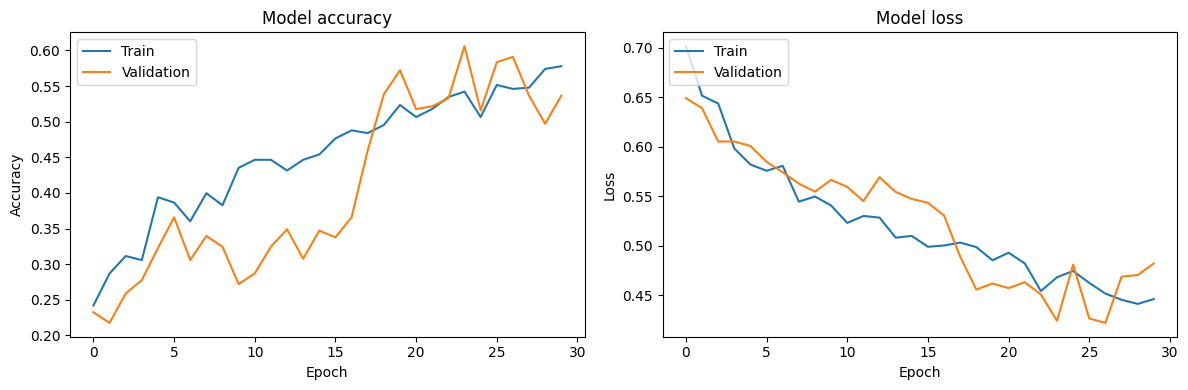

In [ ]:
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Set a seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

def model_2():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (5, 5), strides=1, padding='valid', input_shape=(64, 64, 6), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, (2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(4, activation='softmax'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Set seed for ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    # featurewise_std_normalization=False,
    # samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagen.fit(train_img, seed=seed_value)

batch_size = 30
import matplotlib.pyplot as plt

# ... (Your existing code)

# Set seed for model training
model = model_2()
history = model.fit(datagen.flow(train_img/255, train_labels_cat, seed=seed_value),
                    steps_per_epoch=len(train_img)//batch_size,
                    epochs=30,
                    verbose=1,
                    shuffle=True,
                    validation_data=(test_img/255, test_labels_cat),
                    validation_steps=len(test_img)//batch_size)

# Plot training metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    # Plot trai ning & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_metrics(history)


In [ ]:
# Evaluate the performance as the accuracy on the test set.

model.evaluate(test_img/255, test_labels_cat, batch_size=32)


17/17 [==============================] - 0s 4ms/step - loss: 0.4068 - accuracy: 0.5929


[0.4068489372730255, 0.5928705334663391]

In [ ]:
# the above model is saved as model_with_data_augmentation in the same root file structure.

model.save("model_with_data_augmentation2")



In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Assuming you have a list of file paths for your test images
test_image_paths = ['/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/mother-dau/md_001_1.jpg', '/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/father-son/fs_001_1.jpg']

model = models.load_model('/content/drive/MyDrive/Colab Notebooks/improved_model_with_batch_normalzation_and_tanh')


# Load and preprocess the test images
test_images = []
for image_path in test_image_paths:
    img = load_img(image_path, target_size=(64, 64), color_mode='grayscale')
    img_array = img_to_array(img)

    # Repeat the single channel to create an image with six channels
    img_array = np.repeat(img_array, 6, axis=-1)

    img_array /= 255.0  # Normalize pixel values
    test_images.append(img_array)

test_images = np.array(test_images)

# Assuming you have loaded and compiled your model
# model = ...

# Use the trained model to make predictions
predictions = model.predict(test_images)

# If you have binary classification (e.g., father-son or not), you can threshold the predictions
# For multi-class classification, you can use argmax to get the predicted class
predicted_labels = np.argmax(predictions, axis=1)

# Display the predicted labels
class_labels = ['fd', 'fs', 'md', 'ms']  # Replace with your actual class labels
predicted_class_names = [class_labels[label] for label in predicted_labels]
print("Predicted Labels:", predicted_class_names)


1/1 [==============================] - 0s 327ms/step
Predicted Labels: ['md', 'fs']


In [ ]:
 from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Load the trained model
model = models.load_model('/content/drive/MyDrive/Colab Notebooks/improved_model_with_batch_normalzation_and_tanh')

# Preprocess the two images you want to test
def preprocess_image(image_path, expected_channels=6):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)

    # If the expected channels are different, replicate the channels
    if img_array.shape[-1] != expected_channels:
        img_array = np.concatenate([img_array] * (expected_channels // 3), axis=-1)

    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalization
    return img_array


image_path_1 = '/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/father-dau/fd_001_1.jpg'
image_path_2 = '/content/drive/MyDrive/Colab Notebooks/KinFaceW-I/images/father-dau/fd_001_2.jpg'


img_array_1 = preprocess_image(image_path_1, expected_channels=6)
img_array_2 = preprocess_image(image_path_2, expected_channels=6)

# Feed the images into the model
prediction_1 = model.predict(img_array_1)
prediction_2 = model.predict(img_array_2)

# Interpret the predictions
class_labels = ['fd', 'fs', 'md', 'ms']  # Replace with your actual class labels

predicted_class_1 = class_labels[np.argmax(prediction_1)]
predicted_class_2 = class_labels[np.argmax(prediction_2)]

# Print or use the predictions as needed
print(f'Prediction for image 1: {predicted_class_1}')
print(f'Prediction for image 2: {predicted_class_2}')


1/1 [==============================] - 0s 26ms/step
Prediction for image 1: fs
Prediction for image 2: md


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 60, 60, 16)        2400      
                                                                 
 batch_normalization_16 (Ba  (None, 60, 60, 16)        64        
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 60, 60, 16)        0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        12800     
                                                                 
 batch_normalization_17 (Ba  (None, 26, 26, 32)       